# Recommendation Engine for IBM


## Table of Contents

1. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
2. [Rank Based Recommendations](#Rank)<br>
3. [User-User Based Collaborative Filtering](#User-User)<br>
4. [Matrix Factorization](#Matrix-Fact)<br>
5. [Extras & Concluding](#conclusions)


In [48]:
# pip install progressbar2

Note: you may need to restart the kernel to use updated packages.


In [152]:
# Import of libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import progressbar
from sklearn.metrics import accuracy_score

%matplotlib inline

# Create dataframe with data from two csv files

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Check
df.head(10)

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2
5,1432.0,visualize data with the matplotlib library,b32cd4e1a74e55ac42e4ef484b1f0ad41ee3b1c5
6,1429.0,use deep learning for image classification,3c2de1b0a92728aa53064a22ff7bd7319878ed95
7,593.0,upload files to ibm data science experience us...,3bbca9c41c66c4ecc46bc14eac7b7ab1ab0a5bea
8,1314.0,healthcare python streaming application demo,8b6fb4bbb7a27b336ba35420bf58337d877455c7
9,1185.0,classify tumors with machine learning,35d5799b6ea3ba24f921ed38f7f9a8039ad06ba4


In [153]:
# Check
df_content.head(10)

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4
5,Compose is all about immediacy. You want a new...,Using Compose's PostgreSQL data browser.,Browsing PostgreSQL Data with Compose,Live,5
6,UPGRADING YOUR POSTGRESQL TO 9.5Share on Twitt...,Upgrading your PostgreSQL deployment to versio...,Upgrading your PostgreSQL to 9.5,Live,6
7,Follow Sign in / Sign up 135 8 * Share\r\n * 1...,For a company like Slack that strives to be as...,Data Wrangling at Slack,Live,7
8,* Host\r\n * Competitions\r\n * Datasets\r\n *...,Kaggle is your home for data science. Learn ne...,Data Science Bowl 2017,Live,8
9,THE GRADIENT FLOW\r\nDATA / TECHNOLOGY / CULTU...,[A version of this post appears on the O’Reill...,Using Apache Spark to predict attack vectors a...,Live,9


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

`1.` What is the distribution of how many articles a user interacts with in the dataset?

In [154]:
# Check null values in dataframes

print("Null values in df:")
print(df.isnull().sum())
print()
print("Null values in df_content:")
print(df_content.isnull().sum())

Null values in df:
article_id     0
title          0
email         17
dtype: int64

Null values in df_content:
doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64


In [155]:
# Count user interaction by mail
user_interac = df.email.value_counts(dropna=False)
print(user_interac)

2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
f8c978bcf2ae2fb8885814a9b85ffef2f54c3c76    158
284d0c17905de71e209b376e3309c0b08134f7e2    148
18e7255ee311d4bd78f5993a9f09538e459e3fcc    147
d9032ff68d0fd45dfd18c0c5f7324619bb55362c    147
276d9d8ca0bf52c780b5a3fc554fa69e74f934a3    145
c60bb0a50c324dad0bffd8809d121246baef372b    145
56832a697cb6dbce14700fca18cffcced367057f    144
b2d2c70ed5de62cf8a1d4ded7dd141cfbbdd0388    142
ceef2a24a2a82031246814b73e029edba51e8ea9    140
8dc8d7ec2356b1b106eb3d723f3c234e03ab3f1e    137
e38f123afecb40272ba4c47cb25c96a9533006fa    136
53db7ac77dbb80d6f5c32ed5d19c1a8720078814    132
6c14453c049b1ef4737b08d56c480419794f91c2    131
fd824fc62b4753107e3db7704cd9e8a4a1c961f1    116
c45f9495a76bf95d2633444817f1be8205ad542d    114
12bb8a9740400ced27ae5a7d4c990ac3b7e3c77d

In [156]:
# Median and maximum number of user_article interactios below

top_articles = df.article_id.value_counts(dropna=False)

all_user = np.cumsum(top_articles.values)

# 50% of individuals interact with ____ number of articles or fewer.
median_val = len(all_user[all_user <= len(user_interac)/2])

# The maximum number of user-article interactions by any 1 user is ______.
max_views_by_user = user_interac.iloc[0]

print("50% of individuals interact with this number of articles or fewer:")
print(median_val)
print()
print("The maximum number of user-article interactions by any 1 user is:")
print(max_views_by_user)

50% of individuals interact with this number of articles or fewer:
3

The maximum number of user-article interactions by any 1 user is:
364


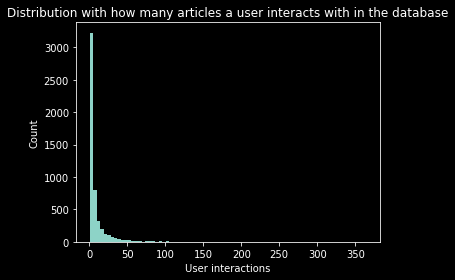

In [158]:
# Distribution of how many articles a user interacts with in the dataframe

plt.figure()
plt.title("'dark_background' style sheet")
plt.style.use('dark_background')
plt.hist(user_interac.values, bins=80)
plt.title('Distribution with how many articles a user interacts with in the database')
plt.xlabel('User interactions')
plt.ylabel('Count')
plt.tight_layout()

plt.show()

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [159]:
# Find and explore duplicate articles
article_count = df_content.article_id.value_counts(dropna=False)
dup_articles = article_count[article_count > 1]

print("Number of article duplicates is: ", len(dup_articles))

Number of article duplicates is:  5


In [160]:
# Remove rows that have the same "article_id" and keep the first

df_content.drop_duplicates(subset=['article_id'], inplace=True)

In [161]:
# Check

article_count = df_content.article_id.value_counts(dropna=False)
dup_articles = article_count[article_count > 1]

print("Number of article duplicates is: ", len(dup_articles))

Number of article duplicates is:  0


`3.` Unique articles and unique users?  

In [162]:
# The number of unique articles that have an interaction with a user

unique_articles = len(top_articles)
print (unique_articles)


714


In [163]:
# The number of unique articles in the dataset (whether they have any interactions or not).<br>
total_art = df_content.shape[0]
print(total_art)

1051


In [164]:
# The number of unique users in the dataset. (excluding null values)
unique_users = len(user_interac)
print(unique_users)

5149


In [165]:
# The number of user-article interactions in the dataset.
user_art_interac = len(df)
print(user_art_interac)

45993


`4.` What is the most viewed **article_id**? How often it was viewed?  

In [166]:
# After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.
# There were a small number of null values, and it was found that all of these null values likely belonged to 
# a single user (which is how they are stored using the function below).

In [167]:
# Most viewed article in the dataframe as a string with one value following the decimal 
most_viewed_article_id = str(top_articles.index[0])

print(most_viewed_article_id)

1429.0


In [168]:
# Most viewed article in the dataset was viewed how many times

max_views = top_articles.iloc[0]

print(max_views)

937


In [169]:
# Map user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

We don't actually have ratings for whether a user liked an article or not.  
We only know that a user has interacted with an article.  
In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Function to return the **n** top articles ordered with most interactions as the top.

In [170]:
def get_top_articles(n, df=df):
    
    '''
    INPUT:
    n - integer - the number of top articles to return
    df - pandas dataframe - df as defined at the top of the code
    
    OUTPUT:
    top_articles - list - A list of the top 'n' article titles 
    
    '''
    
    # Get article ids
    user_by_article = df.groupby(['user_id','article_id'])['title'].count().unstack()
    
    articles_interaction = user_by_article.sum().sort_values(ascending=False)
    articles_index = articles_interaction.iloc[:n].index

    # Get article titles
    df_art_title = df.drop_duplicates(subset=['article_id'])[['article_id','title']]
                                                              
    df_art_title.index = df_art_title.article_id

    # Get list of the top n article titles
    top_articles = list(df_art_title.loc[articles_index].title)
    
    # Return the top article titles from df (not df_content)    
    return top_articles 


In [171]:
print(get_top_articles(20))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'welcome to pixiedust', 'customer demographics and sales', 'total population by country', 'deep learning with tensorflow course by big data university', 'model bike sharing data with spss', 'the nurse assignment problem', 'classify tumors with machine learning', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


In [172]:
def get_top_article_ids(n, df=df):
    
    '''
    INPUT:
    n - integer - the number of top articles to return
    df - pandas dataframe - df as defined at the top of the code 
    
    OUTPUT:
    top_articles - list - A list of the top 'n' article titles IDs
    
    '''
    
    user_by_article = df.groupby(['user_id','article_id'])['title'].count().unstack()
                                  
    articles_interaction = user_by_article.sum().sort_values(ascending=False)
    top_articles_ids = list(articles_interaction.iloc[:n].index)
 
    # Return the top article ids
    return top_articles_ids 

In [173]:
print(get_top_article_ids(10))

[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [174]:
print(get_top_articles(20))
print()
print(get_top_article_ids(20))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'welcome to pixiedust', 'customer demographics and sales', 'total population by country', 'deep learning with tensorflow course by big data university', 'model bike sharing data with spss', 'the nurse assignment problem', 'classify tumors with machine learning', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']

[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0, 

### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Function to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.

* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**.

In [175]:
# create the user-article matrix with 1's and 0's

def create_user_art_matrix(df):
    
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # function for user-article matrix 
    user_art = df.groupby(['user_id','article_id'])['title'].agg(lambda x: 1).unstack()
    user_art.fillna(0, inplace=True)
    
    # return the user_art matrix 
    return user_art

user_art = create_user_art_matrix(df)

# save the matrix in a pickle file
user_art.to_pickle('user_art_matrix.p')

`2.` Function which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  
The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. 
Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

In [176]:
def find_similar_users(user_id, user_art=user_art):
    
    '''
    INPUT:
    user_id - int - a user_id
    user_art - pandas dataframe - matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - list - an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    
    # compute similarity of each user to the provided user
    # remove the own user's id
    user_vector = np.array(user_art.loc[user_id]).reshape(-1, 1)
    Matrix_item = user_art.drop(user_id)
    similarity = np.dot(Matrix_item.values, user_vector)

    # sort by similarity
    df_smly = pd.DataFrame({'user_id': Matrix_item.index,'similarity': similarity.flatten()})
    df_smly.sort_values(by=['similarity'], inplace=True, ascending=False)
    
    # create list of just the ids
    most_similar_users = list(df_smly.user_id)
   
    
    # return a list of the users in order from most to least similar   
    return most_similar_users 
        

`3.` Now we have a function that provides the most similar users to each user, we will want to use these users to find articles you can recommend.  CWe want to return the articles to recommend to each user. 

In [177]:
def get_article_names(article_ids, df=df):
    
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    article_ids = [float(x) for x in article_ids]
    df_2 = df.drop_duplicates(subset=['article_id'])
    df_2.set_index('article_id', inplace=True)
    article_names = list(df_2.loc[article_ids]['title'])
    
    # Return the article names associated with list of article ids
    return article_names 

In [178]:
def get_user_articles(user_id, user_art=user_art):
    
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    #function
    row_user = user_art.loc[user_id]
    article_ids = list(row_user[row_user > 0].index)
    article_ids = [str(x) for x in article_ids]
    article_names = get_article_names(article_ids)
    return article_ids, article_names
    
    # return the ids and names
    return article_ids, article_names

In [179]:
def user_user_recs(user_id, m=10):
    
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
    # Get user articles
    article_ids, _ = get_user_articles(user_id)
    
    # Find similar users
    most_similar_users = find_similar_users(user_id)
    
    # How many users for progress bar
    n_users = len(most_similar_users)

    recs = []
    
    # Create the progressbar
    # Help with progressbar (https://github.com/AlexanderHipp/recommendation-engine-IBM-master-udacity-project/blob/master/Recommendations_with_IBM.ipynb)
    cnter = 0
    bar = progressbar.ProgressBar(maxval=n_users+1, widgets=[progressbar.Bar('=', '[', ']'),' ', progressbar.Percentage()])
    
    bar.start()

    for user in most_similar_users:

        
        # Update the progress bar
        cnter += 1
        bar.update(cnter)

        # Get user articles
        ids, _ = get_user_articles(user)
        article_not_seen = np.setdiff1d(np.array(ids), np.array(article_ids))
        article_not_recs = np.setdiff1d(article_not_seen, np.array(recs))
        recs.extend(list(article_not_recs))

        # If there are more than
        if len(recs) > m:
            break

    bar.finish()

    recs = recs[:10]

    # return your recommendations for this user_id
    return recs

In [180]:
# Check
# Return 10 recommendations for user 1
get_article_names(user_user_recs(1, 10)) 

[========================================================================] 100%


['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings']

`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [181]:
def get_top_sorted_users(user_id, df=df, user_art=user_art):
    
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_art - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    
     # similarity
    user_vector = np.array(user_art.loc[user_id]).reshape(-1, 1)
    Matrix_item = user_art.drop(user_id)
    similarity = np.dot(Matrix_item.values, user_vector)
    
    # sort by similarity
    df_smly = pd.DataFrame({'neighbor_id': Matrix_item.index,'similarity': similarity.flatten()})

    # Number of interaction
    count_inter = df.groupby('user_id')['article_id'].count()
    df_inter = pd.DataFrame({'neighbor_id': count_inter.index,'num_interactions': count_inter.values})

    # Merging the two dataframes
    neighbors_df = df_smly.merge(df_inter)

    # sort the neighbors_df
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], inplace=True, ascending=False)

    
    # Return the dataframe specified in the doc_string
    return neighbors_df

In [182]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    
    # get user articles
    article_ids, _ = get_user_articles(user_id)
    
    # find similar users
    most_similar_users = list(get_top_sorted_users(user_id).neighbor_id)
    
    # How many users for progress bar
    n_users = len(most_similar_users)

    recs = []
    
    # Create the progressbar
    cnter = 0
    bar = progressbar.ProgressBar(maxval=n_users+1,
                                  widgets=[progressbar.Bar('=', '[', ']'), ' ',
                                           progressbar.Percentage()])
    bar.start()

    for user in most_similar_users:
        

        # Update the progress bar
        cnter += 1
        bar.update(cnter)

        # get user articles
        ids, _ = get_user_articles(user)
        article_not_seen = np.setdiff1d(np.array(ids), np.array(article_ids))
        article_not_recs = np.setdiff1d(article_not_seen, np.array(recs))
        recs.extend(list(article_not_recs))

        # If there are more than
        if len(recs) > m:
            break

    bar.finish()

    recs = recs[:10]
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [183]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

[========================================================================] 100%


The top 10 recommendations for user 20 are the following article ids:
['1024.0', '1085.0', '109.0', '1150.0', '1151.0', '1152.0', '1153.0', '1154.0', '1157.0', '1160.0']

The top 10 recommendations for user 20 are the following article names:
['using deep learning to reconstruct high-resolution audio', 'airbnb data for analytics: chicago listings', 'tensorflow quick tips', 'airbnb data for analytics: venice calendar', 'airbnb data for analytics: venice listings', 'airbnb data for analytics: venice reviews', 'airbnb data for analytics: vienna calendar', 'airbnb data for analytics: vienna listings', 'airbnb data for analytics: washington d.c. listings', 'analyze accident reports on amazon emr spark']


`5.` Use functions from above to correctly fill in the solutions to the dictionary below.  Then test dictionary against the solution.

In [184]:
### Tests with a dictionary of results

# Find the user that is most similar to user 1 
user1_most_sim = get_top_sorted_users(1).neighbor_id.values[0]

# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(130).neighbor_id.values[9]

In [185]:
print(user1_most_sim)
print()
print(user131_10th_sim)

3933

4785


`6.` How can we make recommendations for new users?

For a new user, we can use get_top_articles function to suggest top articles.

We can improve our recommendations for a new user by using a self-assessment test. The new user could describe the interessts and we can analyze existing articles and user groups for this interessts. 

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [189]:
new_user = '0.0'

# What would we recommend for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 

new_user_recs = [str(x) for x in get_top_article_ids(10)]



In [190]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0'])

# It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users.


In [191]:
print(new_user_recs)

['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, we will use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` We have already created a **user_art** matrix above in **question 1** of **Part III** above. In the first part we just run the cells to get things set up for the rest of **Part V** of the notebook. 

In [192]:
# Load the matrix here
user_art_matrix = pd.read_pickle('user_art_matrix.p')

In [193]:
# quick look at the matrix
user_art_matrix.head(15)

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, we can use Singular Value Decomposition (SVD) from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-art matrix.

In [194]:
# Perform SVD on the User-Item Matrix Here
# use the built in to get the three matrices
u, s, vt = np.linalg.svd(user_art_matrix)
s.shape, u.shape, vt.shape

((714,), (5149, 5149), (714, 714))

The former analysis provides a data structure with numeric values representing a rating and nulls representing non-interaction. 
This is not a matrix in the linear algebra sense and cannot be operated by Singular Value Decomposition (SVD).
The matrix in this exercise contains binary values with a zero representing non-interaction and a one representing interaction. Although not invertible, this matrix can be processed by SVD.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

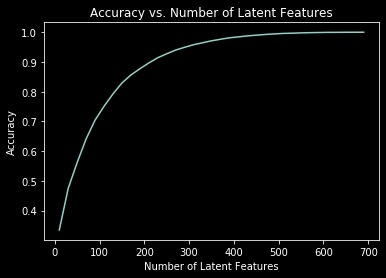

In [195]:
# https://www.quora.com/Meaning-of-latent-features

num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_art_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

We use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [196]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    
    # user-art matrix of the training df
    user_art_train = create_user_art_matrix(df_train)

    # user-art matrix of the testing df
    user_art_test = create_user_art_matrix(df_test)
    
    # test user ids
    test_idx = list(user_art_train.index)  
    
    # test article ids
    test_arts = list(user_art_train.columns)  
    
    return user_art_train, user_art_test, test_idx, test_arts

user_art_train, user_art_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [197]:
# Check
user_art_train.shape

(4487, 714)

In [198]:
# Check
user_art_test.shape

(682, 574)

In [199]:
# Check
print(len(np.setdiff1d(user_art_test.index, user_art_train.index)))
print()
print(len(np.setdiff1d(user_art_test.columns, user_art_train.columns)))

662

0


In [200]:
# Check 

#'How many users can we make predictions for in the test set?': 20
#'How many users in the test set are we not able to make predictions for because of the cold start problem?': 662 
#'How many articles can we make predictions for in the test set?': 574
#'How many articles in the test set are we not able to make predictions for because of the cold start problem?': 0



`5.` Now we use the **user_art_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_art_test** dataset that we can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Then we use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [201]:
# now same but with train and test split

# fit SVD on the user_art_train matrix
# fit svd similar to above
u_train, s_train, vt_train = np.linalg.svd(user_art_train)

In [202]:
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [203]:
# Subset of rows in the user_art_test dataset that we can predict

#  Rows that match the test set
test_idx = user_art_test.index
row_idxs = user_art_train.index.isin(test_idx)
u_test = u_train[row_idxs, :]

#  Columns that match the test set
test_col = user_art_test.columns
col_idxs = user_art_train.columns.isin(test_col)
vt_test = vt_train[:, col_idxs]

In [204]:
# Test data
train_idx = user_art_train.index
row_idxs_2 = user_art_test.index.isin(train_idx)
sub_user_art_test = user_art_test.loc[row_idxs_2]

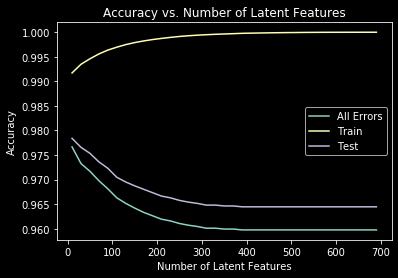

In [205]:
latent_feats = np.arange(10, 700+10, 20)

all_errs, train_errs, test_errs = [], [], []


for k in latent_feats:
    
    # restructure with k latent features
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_art_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_art_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    
    all_errs.append(1 - ((np.sum(user_art_test_preds)+np.sum(np.sum(sub_user_art_test)))/(sub_user_art_test.shape[0]*sub_user_art_test.shape[1])))

    # compute prediction accuracy
    train_errs.append(accuracy_score(user_art_train.values.flatten(), user_art_train_preds.flatten()))
    test_errs.append(accuracy_score(sub_user_art_test.values.flatten(), user_art_test_preds.flatten()))


plt.figure()
plt.title("'dark_background' style sheet")
plt.style.use('dark_background')
plt.plot(latent_feats, all_errs, label='All Errors')
plt.plot(latent_feats, train_errs, label='Train')
plt.plot(latent_feats, test_errs, label='Test')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.legend()
plt.show()

`6.` Comment on the results:


* The figures in the graph above shows that the accuracy of the ML model is very high. 
* But this could be a bit of a misleading result, because in in the data there is a class imbalance. The data as base for the ML model contain much more "0" than "1".


* Training accuracy increase to near 100% as the number of features increases, as we can see in the graph. 
* While the testing accuracy decrease as the number of features increases. This could be due to a limited variety in the datasets. 


* It is very complicated to find a quick solution to this problem. But a solution to this problem could be to perform "Cross Validation" to determine the number of latent features which allow the model to see different subsets of the datasets.

In [208]:
#save 
#from subprocess import call
#call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])